In [66]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse import linalg as sla
from time import time
import math
import seaborn as sns
from scipy.optimize import curve_fit


In [2]:
class Hamiltonian1D:

    def __init__(self, size, x1, x2, hi):
        """
        Initialize a 1D quantum harmonic oscillator Hamiltonian.
        The hamiltonian is multiplied by 2.

        Parameters:
        - size (int): The size of the Hamiltonian matrix.
        - x1, x2 (float): The range of the spatial coordinates.

        Attributes:
        - size (int): The size of the Hamiltonian matrix.
        - grid_space (numpy.ndarray): The spatial grid-space.
        - matrix (scipy.sparse.csc_matrix): The Hamiltonian matrix.
        """
        # @Property: size
        self.size = size
        
        # Physical constants
        omega = 1.0
        hbar  = 1.0
        mass  = 1.0

        # Space points
        grid_space = np.linspace(x1, x2, size, dtype=float)
        dx = grid_space[1] - grid_space[0]

        # @Property: grid-space
        self.grid_space = grid_space

        # Nonzero indexes
        row_indices = np.concatenate([np.arange(size), np.arange(1, size), np.arange(size - 1)])
        col_indices = np.concatenate([np.arange(size), np.arange(size - 1), np.arange(1, size)])

        # Nonzero elements kinetic part
        nonzero_elems = np.zeros((3 * size - 2,), dtype=float)
        nonzero_elems[:size] = 2.0 / dx**2
        nonzero_elems[size:2*size-1] = -1.0 / dx**2
        nonzero_elems[2*size-1:] = -1.0 / dx**2

        # Potential Energy
        V = omega**2 * grid_space**2
        nonzero_elems[:size]+= V
        
        # Sparse matrix Hamiltonian
        matrix = sp.csc_matrix((nonzero_elems, (row_indices, col_indices)), shape=(size, size))

        # @Property: matrix
        self.matrix = matrix
    


    def firstKlevels(self,k):
        """
        Compute the first k eigenvalues and eigenvectors of the Hamiltonian.

        Parameters:
        - k (int): The number of eigenvalues and eigenvectors to compute.

        Returns:
        - engs (numpy.ndarray): Array of k eigenvalues.
        - stts (numpy.ndarray): Array of k eigenvectors.
        """
        # First k eigenvalues and eigenvetors
        engs, stts = sla.eigsh(self.matrix,k,which='SM')

        # Normalization of the eigenvectors
        normalization_factors = np.sqrt(np.trapz(np.abs(stts)**2, self.grid_space, axis=0))
        stts /= normalization_factors
        return engs, stts
    

In [3]:
class Hamiltonian1D_1:
    def __init__(self, size, x1, x2, order=2):
        """
        Initialize a 1D quantum harmonic oscillator Hamiltonian.

        Parameters:
        - size (int): The size of the Hamiltonian matrix.
        - x1, x2 (float): The range of the spatial coordinates.
        - order (int): The order of accuracy for the kinetic part (default is 2).

        Attributes:
        - size (int): The size of the Hamiltonian matrix.
        - grid_space (numpy.ndarray): The spatial grid-space.
        - matrix (scipy.sparse.csc_matrix): The Hamiltonian matrix.
        """
        # @Property: size
        self.size = size

        # Physical constants
        omega = 1.0

        # Space points
        grid_space = np.linspace(x1, x2, size, dtype=float)
        dx = grid_space[1] - grid_space[0]

        # @Property: grid-space
        self.grid_space = grid_space

        # Construct kinetic part
        kinetic_elems = self.construct_kinetic_elements(order, dx)

        # Construct potential part
        potential_elems = self.construct_potential_elements(omega, grid_space)

        # Combine kinetic and potential parts
        kinetic_elems[:size] += potential_elems
        
        # Indexes of non zero element
        if order == 2:

            row_indices = np.concatenate([np.arange(size), np.arange(1, size), np.arange(size - 1)])
            col_indices = np.concatenate([np.arange(size), np.arange(size - 1), np.arange(1, size)])
        
        elif order == 4:
            
            row_indices = np.concatenate([np.arange(size), np.arange(1, size), np.arange(size - 1),
                                          np.arange(2,size), np.arange(size -2)])
            
            col_indices = np.concatenate([np.arange(size), np.arange(size - 1), np.arange(1, size),
                                          np.arange(size-2),np.arange(2,size)])
        else: 
            raise ValueError("Unsupported order of accuracy. Supported orders: 2, 4")
        
        # Sparse matrix Hamiltonian
        matrix = sp.csc_matrix((kinetic_elems, (row_indices, col_indices)), shape=(size, size))

        # @Property: matrix
        self.matrix = matrix

    def construct_kinetic_elements(self, order, dx):
        """
        Construct the kinetic part of the Hamiltonian.

        Parameters:
        - order (int): The order of accuracy.
        - dx (float): The spatial grid spacing.

        Returns:
        - kinetic_elems (numpy.ndarray): Array of kinetic elements.
        """

        if order == 2:
            kinetic_elems = np.zeros((3 * self.size - 2,), dtype=float)

            kinetic_elems[:self.size] = 2.0 / dx**2
            kinetic_elems[self.size:2*self.size-1] = -1.0 / dx**2
            kinetic_elems[2*self.size-1:] = -1.0 / dx**2
        
        elif order == 4:
    
            kinetic_elems = np.zeros((5 * self.size - 6,), dtype=float)
            
            kinetic_elems[:self.size] = 2.5 / dx**2                     # Spacing 0
            kinetic_elems[self.size:2*self.size-1] = -(4/3)/ dx**2      # Spacing -1
            kinetic_elems[2*self.size-1:3*self.size-2] = -(4/3)/ dx**2  # Spacing +1  
            kinetic_elems[3*self.size-2:4*self.size-4] = (1/12) / dx**2 # Sapcing -2
            kinetic_elems[4*self.size-4:] = (1/12)/ dx**2               # Sapcing +2  

        else:
            raise ValueError("Unsupported order of accuracy. Supported orders: 2, 4")

        return kinetic_elems

    def construct_potential_elements(self, omega, grid_space):
        """
        Construct the potential part of the Hamiltonian.

        Parameters:
        - omega (float): The angular frequency of the harmonic oscillator.
        - grid_space (numpy.ndarray): The spatial coordinates.

        Returns:
        - potential_elems (numpy.ndarray): Array of potential elements.
        """
        potential_elems = omega**2 * grid_space**2
        return potential_elems

    def firstKlevels(self, k):
        """
        Compute the first k eigenvalues and eigenvectors of the Hamiltonian.

        Parameters:
        - k (int): The number of eigenvalues and eigenvectors to compute.

        Returns:
        - engs (numpy.ndarray): Array of k eigenvalues.
        - stts (numpy.ndarray): Array of k eigenvectors.
        """
        # First k eigenvalues and eigenvectors
        engs, stts = sla.eigsh(self.matrix, k, which='SM')

        # Normalization of the eigenvectors
        normalization_factors = np.sqrt(np.trapz(np.abs(stts)**2, self.grid_space, axis=0))
        stts /= normalization_factors
        return engs, stts

In [4]:
# Theoretical results: eigenvalues and eigenvectors

def theoretical_eigenvectors(x, n):
    norm = (-1.0)**n / np.sqrt(2**n * np.math.factorial(n) * np.sqrt(np.pi))
    return norm * np.exp(-x**2 / 2) * np.polynomial.hermite.hermval(x, np.eye(n + 1)[-1])

def th_eignvls(k):
    return np.arange(0,2*k,2,dtype=float)+1.0

In [54]:
Xmin=-10
Xmax= 10
N=1000
K=3

A=Hamiltonian1D_1(N,Xmin,Xmax,order=4)
pippo=A.firstKlevels(K)

In [55]:
x=np.linspace(Xmin,Xmax,50)
ciccio=theoretical_eigenvectors(x,1)
topolino=theoretical_eigenvectors(x,0)
pluto=theoretical_eigenvectors(x,2)

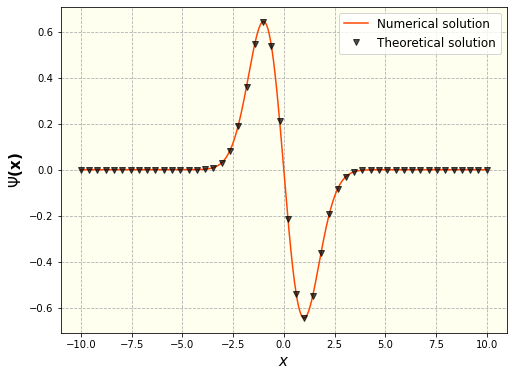

In [61]:
fig, ax =plt.subplots(figsize=(8,6))
ax.plot(A.grid_space,-pippo[1][:,1], label="Numerical solution",color='orangered')
ax.plot(x,ciccio,"v", label="Theoretical solution",color='black',alpha=0.7)
ax.grid(True,linestyle='--')
ax.set_xlabel('$x$',fontsize=15,fontweight='bold')
ax.set_ylabel('$\Psi$(x)',fontsize=15,fontweight='bold')
ax.set_facecolor('ivory')
ax.legend(fontsize=12)
fig.savefig('1D_second')

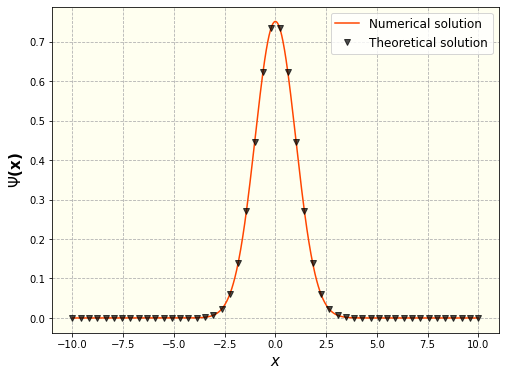

In [60]:
fig, ax =plt.subplots(figsize=(8,6))
ax.plot(A.grid_space,-pippo[1][:,0], label="Numerical solution",color='orangered')
ax.plot(x,topolino,"v", label="Theoretical solution",color='black',alpha=0.7)
ax.grid(True,linestyle='--')
ax.set_xlabel('$x$',fontsize=15,fontweight='bold')
ax.set_ylabel('$\Psi$(x)',fontsize=15,fontweight='bold')
ax.set_facecolor('ivory')
ax.legend(fontsize=12)
fig.savefig('1D_first')

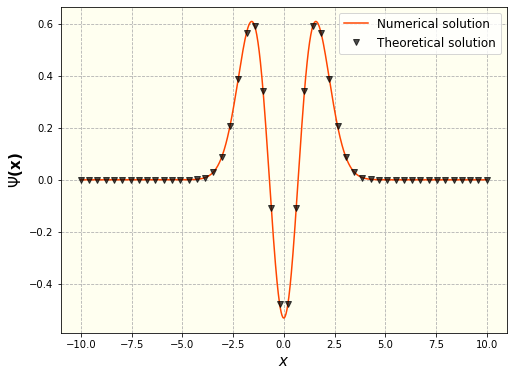

In [59]:
fig, ax =plt.subplots(figsize=(8,6))
ax.plot(A.grid_space,-pippo[1][:,2], label="Numerical solution",color='orangered')
ax.plot(x,pluto,"v", label="Theoretical solution",color='black',alpha=0.7)
ax.grid(True,linestyle='--')
ax.set_xlabel('$x$',fontsize=15,fontweight='bold')
ax.set_ylabel('$\Psi$(x)',fontsize=15,fontweight='bold')
ax.set_facecolor('ivory')
ax.legend(fontsize=12)
fig.savefig('1D_third')

How does it scale?

In [73]:
Xmin=-10
Xmax= 10
scales=np.array([5,20,100,500,1000,5000,10000])
timings = np.zeros((len(scales)))

K=3
for idx, dim in enumerate(scales):
    tic = time()
    A=Hamiltonian1D_1(dim,Xmin,Xmax,order=4)
    pippo=A.firstKlevels(K)
    timings[idx] = time() - tic


In [76]:
def curve(x, a, alpha):
    return a*(x**alpha)
# Fit the curve to each scatter plot
mat_params, _ = curve_fit(curve, scales, timings,maxfev=10000)
x_range=np.linspace(0,10000,1000)
mat_smooth = curve(x_range, *mat_params)


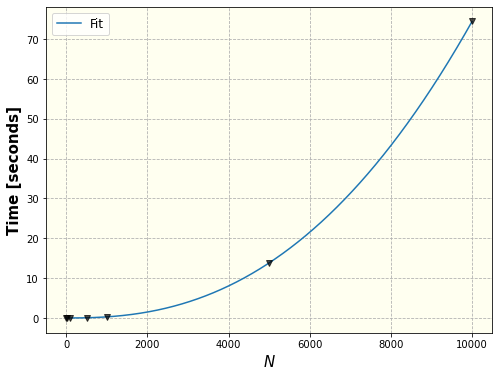

In [77]:
fig, ax =plt.subplots(figsize=(8,6))
ax.plot(x_range,mat_smooth, label='Fit')
ax.plot(scales,timings,"v",color='black',alpha=0.7)
ax.grid(True,linestyle='--')
ax.set_xlabel('$N$',fontsize=15,fontweight='bold')
ax.set_ylabel('Time [seconds]',fontsize=15,fontweight='bold')
ax.set_facecolor('ivory')
ax.legend(fontsize=12)
fig.savefig('Time_scales')

In [78]:
# a
mat_params[0]

1.4377043410292225e-08

In [81]:
#alpha
mat_params[1]

2.428526071246942

Stability

In [82]:
yes =  "\033[1;32m" + u"\N{check mark}" #+ "\033[1;30m"
no =  "\033[1;31m" + u"\N{ballot x}" #+ "\033[1;30m"

Stability order 2

In [93]:
Xmin=-10
Xmax= 10
K=10
N=1000
iterations=100

energies_2=np.zeros((iterations,K),dtype=float)
for i in range(iterations):
    A=Hamiltonian1D_1(N,Xmin,Xmax,order=2)
    pippo=A.firstKlevels(K)
    energies_2[i]=pippo[0]
    print(f'{i}', yes)


0 ✓
1 ✓
2 ✓
3 ✓
4 ✓
5 ✓
6 ✓
7 ✓
8 ✓
9 ✓
10 ✓
11 ✓
12 ✓
13 ✓
14 ✓
15 ✓
16 ✓
17 ✓
18 ✓
19 ✓
20 ✓
21 ✓
22 ✓
23 ✓
24 ✓
25 ✓
26 ✓
27 ✓
28 ✓
29 ✓
30 ✓
31 ✓
32 ✓
33 ✓
34 ✓
35 ✓
36 ✓
37 ✓
38 ✓
39 ✓
40 ✓
41 ✓
42 ✓
43 ✓
44 ✓
45 ✓
46 ✓
47 ✓
48 ✓
49 ✓
50 ✓
51 ✓
52 ✓
53 ✓
54 ✓
55 ✓
56 ✓
57 ✓
58 ✓
59 ✓
60 ✓
61 ✓
62 ✓
63 ✓
64 ✓
65 ✓
66 ✓
67 ✓
68 ✓
69 ✓
70 ✓
71 ✓
72 ✓
73 ✓
74 ✓
75 ✓
76 ✓
77 ✓
78 ✓
79 ✓
80 ✓
81 ✓
82 ✓
83 ✓
84 ✓
85 ✓
86 ✓
87 ✓
88 ✓
89 ✓
90 ✓
91 ✓
92 ✓
93 ✓
94 ✓
95 ✓
96 ✓
97 ✓
98 ✓
99 ✓


Stability order 4

In [94]:
energies_4=np.zeros((iterations,K), dtype=float)

for i in range(iterations):
    A=Hamiltonian1D_1(N,Xmin,Xmax,order=4)
    pippo=A.firstKlevels(K)
    energies_4[i]=pippo[0]
    print(f'{i}', yes)



0 ✓
1 ✓
2 ✓
3 ✓
4 ✓
5 ✓
6 ✓
7 ✓
8 ✓
9 ✓
10 ✓
11 ✓
12 ✓
13 ✓
14 ✓
15 ✓
16 ✓
17 ✓
18 ✓
19 ✓
20 ✓
21 ✓
22 ✓
23 ✓
24 ✓
25 ✓
26 ✓
27 ✓
28 ✓
29 ✓
30 ✓
31 ✓
32 ✓
33 ✓
34 ✓
35 ✓
36 ✓
37 ✓
38 ✓
39 ✓
40 ✓
41 ✓
42 ✓
43 ✓
44 ✓
45 ✓
46 ✓
47 ✓
48 ✓
49 ✓
50 ✓
51 ✓
52 ✓
53 ✓
54 ✓
55 ✓
56 ✓
57 ✓
58 ✓
59 ✓
60 ✓
61 ✓
62 ✓
63 ✓
64 ✓
65 ✓
66 ✓
67 ✓
68 ✓
69 ✓
70 ✓
71 ✓
72 ✓
73 ✓
74 ✓
75 ✓
76 ✓
77 ✓
78 ✓
79 ✓
80 ✓
81 ✓
82 ✓
83 ✓
84 ✓
85 ✓
86 ✓
87 ✓
88 ✓
89 ✓
90 ✓
91 ✓
92 ✓
93 ✓
94 ✓
95 ✓
96 ✓
97 ✓
98 ✓
99 ✓


In [97]:
print('The std is : ')
for i in range(3):

    print(np.std(energies_2[:,i], dtype=float))

print('The mean is : ')
for i in range(3):

    print(np.mean(energies_2[:,i], dtype=float))
    

The std is : 
3.1034174879938204e-13
4.0134198406520543e-13
3.3622958085347346e-13
The mean is : 
0.9999749492973063
2.9998747439762514
4.999674327057075


In [98]:
print('The std is : ')
for i in range(3):

    print(np.std(energies_4[:,i], dtype=float))

print('The mean is : ')
for i in range(3):

    print(np.mean(energies_4[:,i], dtype=float))

The std is : 
4.3176475323127245e-13
4.3873044997483354e-13
3.9732805299924393e-13
The mean is : 
0.999999996654148
2.9999999765773695
4.999999916350207
